# ДЗ 1

In [1]:
#!pip3 install torchsummary

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np

## Вариант 3: Контроль количества параметров

**Цель:** Создание компактной сети с не более чем 50,000 параметров.

**Условия:**
- Максимум 50,000 параметров
- Минимум один слой 1x1 свертки для уменьшения числа каналов
- Подсчет параметров каждого слоя

In [3]:
class CompactNet(nn.Module):
    def __init__(self, num_classes=10):
        super(CompactNet, self).__init__()
        
        # Блок 1: Начальная обработка
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)  # 3*16*3*3 + 16 = 448
        self.bn1 = nn.BatchNorm2d(16)  # 16*2 = 32
        
        # Блок 2: Увеличение каналов
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # 16*32*3*3 + 32 = 4640
        self.bn2 = nn.BatchNorm2d(32)  # 32*2 = 64
        
        # Блок 3: 1x1 свертка для уменьшения каналов
        self.conv3_1x1 = nn.Conv2d(32, 16, kernel_size=1)  # 32*16*1*1 + 16 = 528
        self.bn3 = nn.BatchNorm2d(16)  # 16*2 = 32
        
        # Блок 4: Расширение после сжатия
        self.conv4 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # 16*32*3*3 + 32 = 4640
        self.bn4 = nn.BatchNorm2d(32)  # 32*2 = 64
        
        # Блок 5: Еще одна 1x1 свертка для дополнительного сжатия
        self.conv5_1x1 = nn.Conv2d(32, 24, kernel_size=1)  # 32*24*1*1 + 24 = 792
        self.bn5 = nn.BatchNorm2d(24)  # 24*2 = 48
        
        # Блок 6: Финальная обработка
        self.conv6 = nn.Conv2d(24, 32, kernel_size=3, padding=1)  # 24*32*3*3 + 32 = 6944
        self.bn6 = nn.BatchNorm2d(32)  # 32*2 = 64
        
        # Global Average Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        
        # Финальный классификатор
        self.fc = nn.Linear(32, num_classes)  # 32*10 + 10 = 330
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)  # 32x32 -> 16x16
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)  # 16x16 -> 8x8
        
        x = F.relu(self.bn3(self.conv3_1x1(x)))
        
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.max_pool2d(x, 2)  # 8x8 -> 4x4
        
        x = F.relu(self.bn5(self.conv5_1x1(x)))
        
        x = F.relu(self.bn6(self.conv6(x)))
        
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        
        x = self.fc(x)
        return x

In [4]:
model = CompactNet(num_classes=10)
print(model)

CompactNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3_1x1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
  (bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5_1x1): Conv2d(32, 24, kernel_size=(1, 1), stride=(1, 1))
  (bn5): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(24, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (global_avg_poo

In [5]:
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
       BatchNorm2d-2           [-1, 16, 32, 32]              32
            Conv2d-3           [-1, 32, 16, 16]           4,640
       BatchNorm2d-4           [-1, 32, 16, 16]              64
            Conv2d-5             [-1, 16, 8, 8]             528
       BatchNorm2d-6             [-1, 16, 8, 8]              32
            Conv2d-7             [-1, 32, 8, 8]           4,640
       BatchNorm2d-8             [-1, 32, 8, 8]              64
            Conv2d-9             [-1, 24, 4, 4]             792
      BatchNorm2d-10             [-1, 24, 4, 4]              48
           Conv2d-11             [-1, 32, 4, 4]           6,944
      BatchNorm2d-12             [-1, 32, 4, 4]              64
AdaptiveAvgPool2d-13             [-1, 32, 1, 1]               0
           Linear-14                   

Модель получилась на 18,626 параметров

Проверим, что модель нормально работает (при прямом проходе)

In [6]:
test_input = torch.randn(5, 3, 32, 32)
print(f"Размер входа: {test_input.shape}")

model.eval()
with torch.no_grad():
    output = model(test_input)

print(f"Размер выхода: {output.shape}")
print(f"Выход модели: {output}")

Размер входа: torch.Size([5, 3, 32, 32])
Размер выхода: torch.Size([5, 10])
Выход модели: tensor([[ 0.0718,  0.0446,  0.1468, -0.1095, -0.0304, -0.0829, -0.0983, -0.0944,
          0.1556, -0.1154],
        [ 0.0704,  0.0442,  0.1473, -0.1101, -0.0301, -0.0823, -0.0968, -0.0925,
          0.1559, -0.1161],
        [ 0.0706,  0.0453,  0.1475, -0.1096, -0.0299, -0.0830, -0.0979, -0.0938,
          0.1557, -0.1155],
        [ 0.0712,  0.0443,  0.1463, -0.1095, -0.0297, -0.0819, -0.0966, -0.0937,
          0.1555, -0.1157],
        [ 0.0714,  0.0454,  0.1473, -0.1092, -0.0313, -0.0823, -0.0980, -0.0939,
          0.1562, -0.1153]])


# Вариант 5. Контроль градиентов через глубину
**Цель**: Изучение поведения градиентов в глубокой сети.

- Разработайте сеть с не менее 6 слоев, которая выводит тензор (batch, 64, 8, 8).
- Условие: Слои должны чередоваться между Conv2d и ReLU, при этом градиенты первого слоя должны быть меньше градиентов последнего после одной итерации backward() на случайных данных.
- Эксперимент: Визуализируйте градиенты по слоям и объясните, почему градиенты убывают или растут.

In [7]:
class DeepGradientNet(nn.Module):

    def __init__(self, input_channels=3):
        super(DeepGradientNet, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 48, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(48, 48, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(48, 64, kernel_size=3, stride=2, padding=1)
        self.conv6 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv7 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))  # Слой 1
        x = F.relu(self.conv2(x))  # Слой 2
        x = F.relu(self.conv3(x))  # Слой 3 (32x32 -> 16x16)
        x = F.relu(self.conv4(x))  # Слой 4
        x = F.relu(self.conv5(x))  # Слой 5 (16x16 -> 8x8)
        x = F.relu(self.conv6(x))  # Слой 6
        x = F.relu(self.conv7(x))  # Слой 7
        return x
    
    def get_conv_layers(self):
        return [self.conv1, self.conv2, self.conv3, self.conv4, 
                self.conv5, self.conv6, self.conv7]

In [8]:
gradient_model = DeepGradientNet(input_channels=3)
print(gradient_model)

DeepGradientNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv4): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(48, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [9]:
test_input = torch.randn(4, 3, 32, 32)  # batch=4, channels=3, size=32x32
output = gradient_model(test_input)
print(f"Входной размер: {test_input.shape}")
print(f"Выходной размер: {output.shape}")
print("Ожидаемый размер: (4, 64, 8, 8)")

Входной размер: torch.Size([4, 3, 32, 32])
Выходной размер: torch.Size([4, 64, 8, 8])
Ожидаемый размер: (4, 64, 8, 8)


In [10]:
conv_layers = gradient_model.get_conv_layers()

# Создание случайных данных и целевого тензора
batch_size = 8
input_data = torch.randn(batch_size, 3, 32, 32, requires_grad=True)
target = torch.randn(batch_size, 64, 8, 8)

gradient_model.train()
output = gradient_model(input_data)
loss = F.mse_loss(output, target)
print(f"Значение функции потерь: {loss.item():.6f}")
loss.backward()

gradients = {}
gradient_norms = {}

for idx, layer in enumerate(conv_layers, 1):
    if layer.weight.grad is not None:
        grad = layer.weight.grad
        gradients[f'conv{idx}'] = grad
        grad_norm = grad.norm().item()
        gradient_norms[f'conv{idx}'] = grad_norm

Значение функции потерь: 1.001253


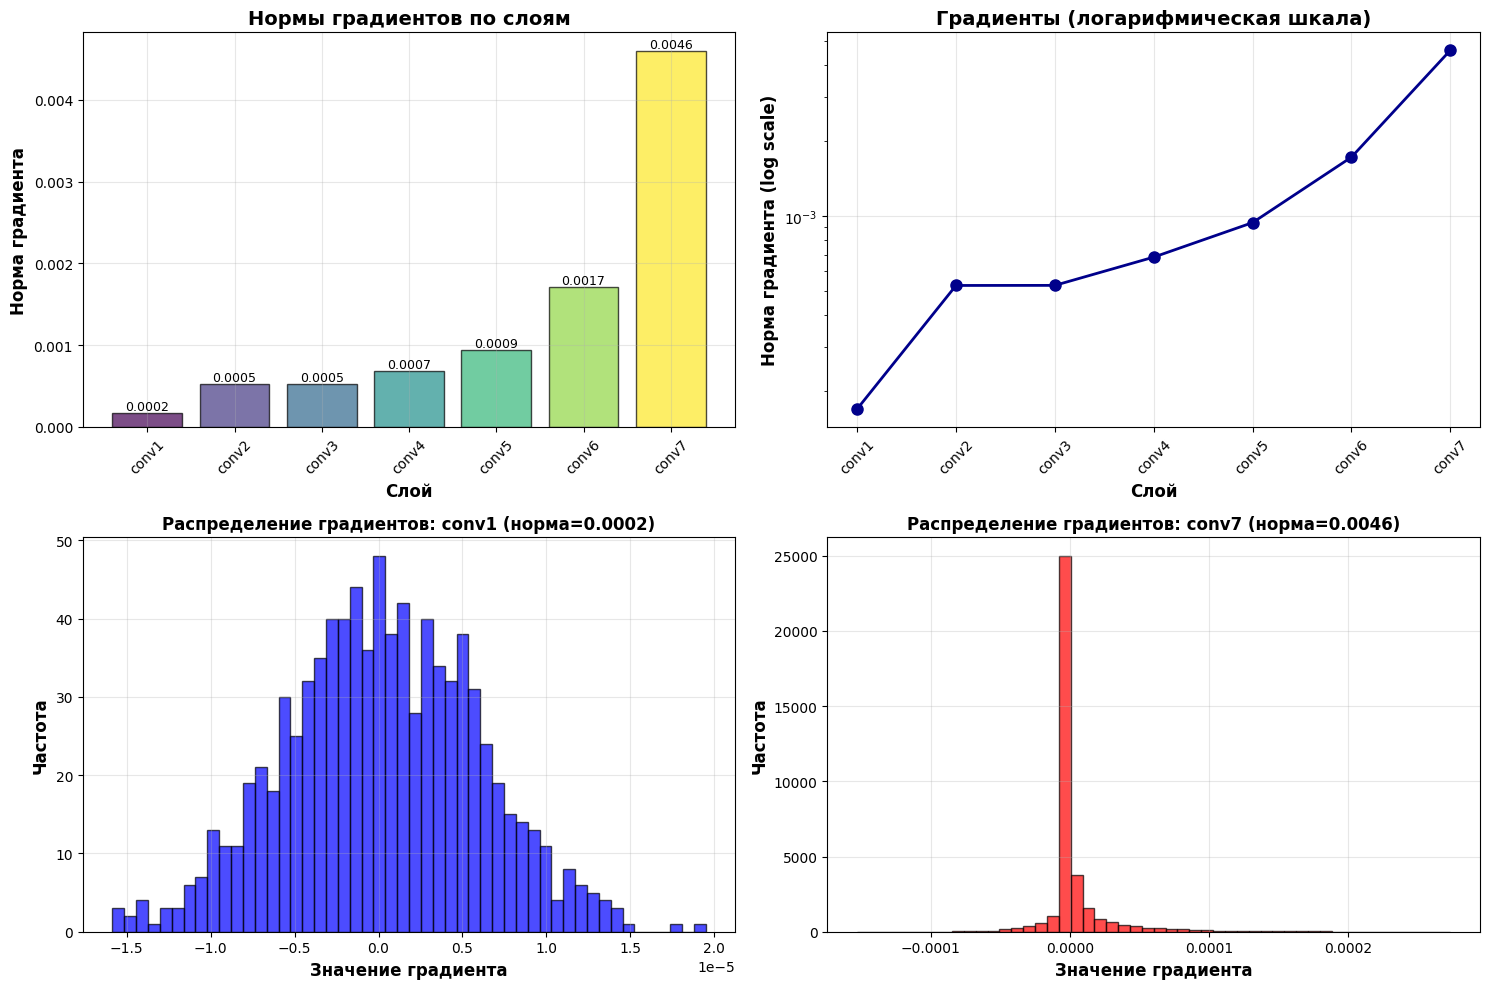

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Нормы градиентов
ax1 = axes[0, 0]
layers = list(gradient_norms.keys())
norms = list(gradient_norms.values())
colors = plt.cm.viridis(np.linspace(0, 1, len(layers)))

bars = ax1.bar(layers, norms, color=colors, alpha=0.7, edgecolor='black')
ax1.set_xlabel('Слой', fontsize=12, fontweight='bold')
ax1.set_ylabel('Норма градиента', fontsize=12, fontweight='bold')
ax1.set_title('Нормы градиентов по слоям', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

for bar, norm in zip(bars, norms):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{norm:.4f}',
             ha='center', va='bottom', fontsize=9)

# 2. Логарифмическая шкала
ax2 = axes[0, 1]
ax2.semilogy(layers, norms, 'o-', linewidth=2, markersize=8, color='darkblue')
ax2.set_xlabel('Слой', fontsize=12, fontweight='bold')
ax2.set_ylabel('Норма градиента (log scale)', fontsize=12, fontweight='bold')
ax2.set_title('Градиенты (логарифмическая шкала)', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

# 3. Распределение градиентов первого слоя
ax3 = axes[1, 0]
first_layer_grad = gradients['conv1'].flatten().detach().numpy()
ax3.hist(first_layer_grad, bins=50, alpha=0.7, color='blue', edgecolor='black')
ax3.set_xlabel('Значение градиента', fontsize=12, fontweight='bold')
ax3.set_ylabel('Частота', fontsize=12, fontweight='bold')
ax3.set_title(f'Распределение градиентов: conv1 (норма={gradient_norms["conv1"]:.4f})', 
              fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)

# 4. Распределение градиентов последнего слоя
ax4 = axes[1, 1]
last_layer_grad = gradients['conv7'].flatten().detach().numpy()
ax4.hist(last_layer_grad, bins=50, alpha=0.7, color='red', edgecolor='black')
ax4.set_xlabel('Значение градиента', fontsize=12, fontweight='bold')
ax4.set_ylabel('Частота', fontsize=12, fontweight='bold')
ax4.set_title(f'Распределение градиентов: conv7 (норма={gradient_norms["conv7"]:.4f})', 
              fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [12]:
first_grad_norm = gradient_norms['conv1']
last_grad_norm = gradient_norms['conv7']
print(f"Норма градиента первого слоя (conv1): {first_grad_norm:.6f}")
print(f"Норма градиента последнего слоя (conv7): {last_grad_norm:.6f}")
print(f"Градиенты первого слоя меньше градиентов последнего: {first_grad_norm < last_grad_norm}")

Норма градиента первого слоя (conv1): 0.000169
Норма градиента последнего слоя (conv7): 0.004595
Градиенты первого слоя меньше градиентов последнего: True


Выводы:
Здесь наблюдается проблема затухающих градиентов. Из-за того, что градиенты распространяются от выхода к входу через chain rule и производная от RELU для отрицательных значений равна нулю, градиенты уменьшаются с каждым слоем:
$$ \frac{\partial RELU}{\partial x} = I[x > 0] $$
$$ \frac{\partial Loss}{\partial w_1} = \frac{\partial Loss}{\partial w_n} \frac{\partial w_n}{\partial w_{n-1}} ... \frac{\partial w_2}{\partial w_1} $$

Из-за этого первые слои обучаются медленно, а последние слои обучаются быстро и из-за этого может возникнуть дисбаланс в обучении.

Такую проблему можно решить множеством способов, например:
- Batch Normalization - нормализация активаций
- Residual connections (ResNet) - skip connections
- Правильная инициализация весов (Xavier, He)
- Gradient clipping - ограничение градиентов
- Использование других активаций (LeakyReLU, ELU)